In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=2,       
        drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output)
        self.w2 = nn.Linear(self.attn_input, self.attn_output)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(DENSE_OUT, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, BATCH_SIZE, self.hidden_dim1 // 2)    #4*B*(h1/2)
#         hidden = Variable(hidden.data, requires_grad=True)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(BATCH_SIZE, self.hidden_dim2)              #B*h2
#         hidden = Variable(hidden.data, requires_grad=True)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(BATCH_SIZE, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(BATCH_SIZE, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(BATCH_SIZE, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence):
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        # bn
        bilstm_out = self.bn(bilstm_out)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            if length==0:
                
#                 fake_hidden=(100)
#                 noise_x = random(100)
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
#                 fake_hidden=h
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]             
            label = self.label_embed(ent_output)                             #B*LE,[128, 3]
            
            s_ent_output = softmax_entity(ent_output)
            
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
            encoder_sequence_l.append(torch.cat((to_tags,label),1))          
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(BATCH_SIZE*MAX_LEN, self.ent_size), \
               rel_tensor.view(BATCH_SIZE*MAX_LEN*MAX_LEN, self.rel_size)

In [5]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

relation_data_old = root+'facial_r.old.train'
# relation_data = root+'facial_r.train'
relation_data = root+'facial_r2.train'
schema_root = root+'schema.txt'
dev_data = root+'facial_r2.dev'


UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'
rule = ('FUNC', 'ApplyTo', 'STAT')

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100
BATCH_SIZE = 18

EMBEDDING_DIM = 20
HIDDEN_DIM1 = 10
HIDDEN_DIM2 = 8
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_OUT = 6

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss()
# criterion_rel = nn.CrossEntropyLoss()
criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 70
print_every = 12
all_ent_loss = []
all_rel_loss = []
total_loss = 0 # Reset every plot_every iters
loss = 0
ent_loss = 0

start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batch_ent = batch_ent.view(BATCH_SIZE*MAX_LEN)
        batch_rel = batch_rel.view(BATCH_SIZE*MAX_LEN*MAX_LEN)
        
        loss_ent = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        loss_rel = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = loss_ent+loss_rel
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        
        if step % print_every == 1:
            all_ent_loss.append(loss_ent.cpu())
            all_rel_loss.append(loss_rel.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        val_loss_ent = criterion_tag(ent_output.cpu(), batch_ent.view(BATCH_SIZE*MAX_LEN)) 
        val_loss_rel = criterion_rel(rel_output.cpu(), batch_rel.view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch, loss_ent, loss_rel, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch)), val_loss_ent, val_loss_rel))


  1%|▏         | 1/70 [00:07<08:31,  7.41s/it]

epoch: 0 | ent loss 0.4766 | rel loss 0.0417 | total loss 0.5184
         | val ent loss 0.4090 | val rel loss 0.0383


  3%|▎         | 2/70 [00:15<08:33,  7.55s/it]

epoch: 1 | ent loss 0.3403 | rel loss 0.0187 | total loss 0.3590
         | val ent loss 0.2943 | val rel loss 0.0172


  4%|▍         | 3/70 [00:22<08:33,  7.66s/it]

epoch: 2 | ent loss 0.2997 | rel loss 0.0129 | total loss 0.3126
         | val ent loss 0.2694 | val rel loss 0.0108


  6%|▌         | 4/70 [00:30<08:24,  7.64s/it]

epoch: 3 | ent loss 0.3096 | rel loss 0.0108 | total loss 0.3204
         | val ent loss 0.2450 | val rel loss 0.0079


  7%|▋         | 5/70 [00:38<08:16,  7.64s/it]

epoch: 4 | ent loss 0.2927 | rel loss 0.0094 | total loss 0.3020
         | val ent loss 0.2547 | val rel loss 0.0069


  9%|▊         | 6/70 [00:45<08:05,  7.58s/it]

epoch: 5 | ent loss 0.2756 | rel loss 0.0072 | total loss 0.2829
         | val ent loss 0.2458 | val rel loss 0.0058


 10%|█         | 7/70 [00:52<07:56,  7.57s/it]

epoch: 6 | ent loss 0.2439 | rel loss 0.0087 | total loss 0.2526
         | val ent loss 0.1840 | val rel loss 0.0059


 11%|█▏        | 8/70 [01:00<07:48,  7.56s/it]

epoch: 7 | ent loss 0.1481 | rel loss 0.0067 | total loss 0.1547
         | val ent loss 0.1511 | val rel loss 0.0048


 13%|█▎        | 9/70 [01:07<07:40,  7.55s/it]

epoch: 8 | ent loss 0.1300 | rel loss 0.0058 | total loss 0.1358
         | val ent loss 0.1327 | val rel loss 0.0049


 14%|█▍        | 10/70 [01:15<07:33,  7.55s/it]

epoch: 9 | ent loss 0.1175 | rel loss 0.0044 | total loss 0.1218
         | val ent loss 0.1341 | val rel loss 0.0036


 16%|█▌        | 11/70 [01:21<07:17,  7.41s/it]

epoch: 10 | ent loss 0.1127 | rel loss 0.0042 | total loss 0.1169
          | val ent loss 0.1309 | val rel loss 0.0034


 17%|█▋        | 12/70 [01:29<07:10,  7.42s/it]

epoch: 11 | ent loss 0.1056 | rel loss 0.0039 | total loss 0.1094
          | val ent loss 0.1074 | val rel loss 0.0030


 19%|█▊        | 13/70 [01:36<07:03,  7.42s/it]

epoch: 12 | ent loss 0.0927 | rel loss 0.0033 | total loss 0.0960
          | val ent loss 0.0922 | val rel loss 0.0032


 20%|██        | 14/70 [01:42<06:49,  7.32s/it]

epoch: 13 | ent loss 0.1068 | rel loss 0.0038 | total loss 0.1106
          | val ent loss 0.0895 | val rel loss 0.0025


 21%|██▏       | 15/70 [01:49<06:41,  7.30s/it]

epoch: 14 | ent loss 0.0535 | rel loss 0.0024 | total loss 0.0559
          | val ent loss 0.0985 | val rel loss 0.0028


 23%|██▎       | 16/70 [01:56<06:34,  7.30s/it]

epoch: 15 | ent loss 0.0582 | rel loss 0.0028 | total loss 0.0610
          | val ent loss 0.0787 | val rel loss 0.0021


 24%|██▍       | 17/70 [02:04<06:27,  7.31s/it]

epoch: 16 | ent loss 0.0536 | rel loss 0.0029 | total loss 0.0565
          | val ent loss 0.0696 | val rel loss 0.0024


 26%|██▌       | 18/70 [02:11<06:21,  7.33s/it]

epoch: 17 | ent loss 0.0443 | rel loss 0.0026 | total loss 0.0469
          | val ent loss 0.0704 | val rel loss 0.0022


 27%|██▋       | 19/70 [02:19<06:14,  7.35s/it]

epoch: 18 | ent loss 0.0325 | rel loss 0.0026 | total loss 0.0351
          | val ent loss 0.0624 | val rel loss 0.0019


 29%|██▊       | 20/70 [02:27<06:07,  7.36s/it]

epoch: 19 | ent loss 0.0333 | rel loss 0.0022 | total loss 0.0355
          | val ent loss 0.0729 | val rel loss 0.0019


 30%|███       | 21/70 [02:34<06:01,  7.37s/it]

epoch: 20 | ent loss 0.0230 | rel loss 0.0019 | total loss 0.0249
          | val ent loss 0.0744 | val rel loss 0.0018


 31%|███▏      | 22/70 [02:42<05:53,  7.37s/it]

epoch: 21 | ent loss 0.0219 | rel loss 0.0022 | total loss 0.0241
          | val ent loss 0.0456 | val rel loss 0.0016


 33%|███▎      | 23/70 [02:49<05:47,  7.39s/it]

epoch: 22 | ent loss 0.0249 | rel loss 0.0019 | total loss 0.0269
          | val ent loss 0.0583 | val rel loss 0.0016


 34%|███▍      | 24/70 [02:57<05:40,  7.39s/it]

epoch: 23 | ent loss 0.0224 | rel loss 0.0021 | total loss 0.0245
          | val ent loss 0.0660 | val rel loss 0.0014


 36%|███▌      | 25/70 [03:05<05:33,  7.41s/it]

epoch: 24 | ent loss 0.0184 | rel loss 0.0017 | total loss 0.0201
          | val ent loss 0.0799 | val rel loss 0.0016


 37%|███▋      | 26/70 [03:13<05:27,  7.44s/it]

epoch: 25 | ent loss 0.0280 | rel loss 0.0019 | total loss 0.0298
          | val ent loss 0.0632 | val rel loss 0.0016


 39%|███▊      | 27/70 [03:21<05:20,  7.45s/it]

epoch: 26 | ent loss 0.0276 | rel loss 0.0024 | total loss 0.0300
          | val ent loss 0.0504 | val rel loss 0.0018


 40%|████      | 28/70 [03:28<05:13,  7.46s/it]

epoch: 27 | ent loss 0.0130 | rel loss 0.0014 | total loss 0.0145
          | val ent loss 0.0646 | val rel loss 0.0018


 41%|████▏     | 29/70 [03:36<05:06,  7.46s/it]

epoch: 28 | ent loss 0.0139 | rel loss 0.0015 | total loss 0.0155
          | val ent loss 0.0631 | val rel loss 0.0014


 43%|████▎     | 30/70 [03:44<04:58,  7.47s/it]

epoch: 29 | ent loss 0.0144 | rel loss 0.0015 | total loss 0.0160
          | val ent loss 0.0532 | val rel loss 0.0015


 44%|████▍     | 31/70 [03:50<04:50,  7.45s/it]

epoch: 30 | ent loss 0.0191 | rel loss 0.0017 | total loss 0.0207
          | val ent loss 0.0451 | val rel loss 0.0013


 46%|████▌     | 32/70 [03:58<04:42,  7.44s/it]

epoch: 31 | ent loss 0.0107 | rel loss 0.0013 | total loss 0.0120
          | val ent loss 0.0496 | val rel loss 0.0014


 47%|████▋     | 33/70 [04:04<04:34,  7.41s/it]

epoch: 32 | ent loss 0.0148 | rel loss 0.0018 | total loss 0.0166
          | val ent loss 0.0642 | val rel loss 0.0016


 49%|████▊     | 34/70 [04:12<04:26,  7.41s/it]

epoch: 33 | ent loss 0.0158 | rel loss 0.0017 | total loss 0.0174
          | val ent loss 0.0574 | val rel loss 0.0013


 50%|█████     | 35/70 [04:19<04:19,  7.42s/it]

epoch: 34 | ent loss 0.0138 | rel loss 0.0013 | total loss 0.0151
          | val ent loss 0.0578 | val rel loss 0.0013


 51%|█████▏    | 36/70 [04:27<04:12,  7.43s/it]

epoch: 35 | ent loss 0.0112 | rel loss 0.0014 | total loss 0.0126
          | val ent loss 0.0563 | val rel loss 0.0012


 53%|█████▎    | 37/70 [04:35<04:05,  7.44s/it]

epoch: 36 | ent loss 0.0126 | rel loss 0.0016 | total loss 0.0142
          | val ent loss 0.0591 | val rel loss 0.0012


 54%|█████▍    | 38/70 [04:42<03:58,  7.44s/it]

epoch: 37 | ent loss 0.0184 | rel loss 0.0014 | total loss 0.0198
          | val ent loss 0.0548 | val rel loss 0.0013


 56%|█████▌    | 39/70 [04:50<03:50,  7.44s/it]

epoch: 38 | ent loss 0.0169 | rel loss 0.0018 | total loss 0.0187
          | val ent loss 0.0606 | val rel loss 0.0012


 57%|█████▋    | 40/70 [04:57<03:42,  7.43s/it]

epoch: 39 | ent loss 0.0246 | rel loss 0.0013 | total loss 0.0260
          | val ent loss 0.0619 | val rel loss 0.0010


 59%|█████▊    | 41/70 [05:03<03:34,  7.41s/it]

epoch: 40 | ent loss 0.0164 | rel loss 0.0014 | total loss 0.0178
          | val ent loss 0.0671 | val rel loss 0.0014


 60%|██████    | 42/70 [05:10<03:27,  7.40s/it]

epoch: 41 | ent loss 0.0110 | rel loss 0.0013 | total loss 0.0123
          | val ent loss 0.0646 | val rel loss 0.0014


 61%|██████▏   | 43/70 [05:17<03:19,  7.39s/it]

epoch: 42 | ent loss 0.0063 | rel loss 0.0012 | total loss 0.0074
          | val ent loss 0.0629 | val rel loss 0.0013


 63%|██████▎   | 44/70 [05:25<03:12,  7.39s/it]

epoch: 43 | ent loss 0.0134 | rel loss 0.0012 | total loss 0.0147
          | val ent loss 0.0786 | val rel loss 0.0014


 64%|██████▍   | 45/70 [05:33<03:05,  7.40s/it]

epoch: 44 | ent loss 0.0055 | rel loss 0.0012 | total loss 0.0066
          | val ent loss 0.0633 | val rel loss 0.0011


 66%|██████▌   | 46/70 [05:39<02:57,  7.38s/it]

epoch: 45 | ent loss 0.0130 | rel loss 0.0014 | total loss 0.0144
          | val ent loss 0.0493 | val rel loss 0.0012


 67%|██████▋   | 47/70 [05:47<02:50,  7.39s/it]

epoch: 46 | ent loss 0.0087 | rel loss 0.0013 | total loss 0.0100
          | val ent loss 0.0533 | val rel loss 0.0012


 69%|██████▊   | 48/70 [05:55<02:42,  7.40s/it]

epoch: 47 | ent loss 0.0058 | rel loss 0.0011 | total loss 0.0069
          | val ent loss 0.0444 | val rel loss 0.0010


 70%|███████   | 49/70 [06:02<02:35,  7.41s/it]

epoch: 48 | ent loss 0.0054 | rel loss 0.0009 | total loss 0.0063
          | val ent loss 0.0469 | val rel loss 0.0011


 71%|███████▏  | 50/70 [06:09<02:27,  7.40s/it]

epoch: 49 | ent loss 0.0072 | rel loss 0.0011 | total loss 0.0083
          | val ent loss 0.0348 | val rel loss 0.0011


 73%|███████▎  | 51/70 [06:17<02:20,  7.39s/it]

epoch: 50 | ent loss 0.0096 | rel loss 0.0010 | total loss 0.0106
          | val ent loss 0.0678 | val rel loss 0.0009


 74%|███████▍  | 52/70 [06:24<02:13,  7.40s/it]

epoch: 51 | ent loss 0.0061 | rel loss 0.0011 | total loss 0.0072
          | val ent loss 0.0760 | val rel loss 0.0012


 76%|███████▌  | 53/70 [06:32<02:05,  7.40s/it]

epoch: 52 | ent loss 0.0122 | rel loss 0.0014 | total loss 0.0136
          | val ent loss 0.0424 | val rel loss 0.0012


 77%|███████▋  | 54/70 [06:40<01:58,  7.41s/it]

epoch: 53 | ent loss 0.0096 | rel loss 0.0010 | total loss 0.0106
          | val ent loss 0.0379 | val rel loss 0.0009


 79%|███████▊  | 55/70 [06:46<01:50,  7.39s/it]

epoch: 54 | ent loss 0.0082 | rel loss 0.0010 | total loss 0.0092
          | val ent loss 0.0639 | val rel loss 0.0012


 80%|████████  | 56/70 [06:54<01:43,  7.40s/it]

epoch: 55 | ent loss 0.0040 | rel loss 0.0009 | total loss 0.0049
          | val ent loss 0.0564 | val rel loss 0.0012


 81%|████████▏ | 57/70 [07:02<01:36,  7.41s/it]

epoch: 56 | ent loss 0.0039 | rel loss 0.0009 | total loss 0.0049
          | val ent loss 0.0472 | val rel loss 0.0009


 83%|████████▎ | 58/70 [07:10<01:29,  7.42s/it]

epoch: 57 | ent loss 0.0100 | rel loss 0.0011 | total loss 0.0111
          | val ent loss 0.0548 | val rel loss 0.0013


 84%|████████▍ | 59/70 [07:17<01:21,  7.42s/it]

epoch: 58 | ent loss 0.0085 | rel loss 0.0013 | total loss 0.0097
          | val ent loss 0.0732 | val rel loss 0.0011


 86%|████████▌ | 60/70 [07:25<01:14,  7.43s/it]

epoch: 59 | ent loss 0.0033 | rel loss 0.0010 | total loss 0.0043
          | val ent loss 0.0575 | val rel loss 0.0011


 87%|████████▋ | 61/70 [07:33<01:06,  7.44s/it]

epoch: 60 | ent loss 0.0049 | rel loss 0.0013 | total loss 0.0062
          | val ent loss 0.0530 | val rel loss 0.0010


 89%|████████▊ | 62/70 [07:41<00:59,  7.44s/it]

epoch: 61 | ent loss 0.0074 | rel loss 0.0010 | total loss 0.0084
          | val ent loss 0.0440 | val rel loss 0.0011


 90%|█████████ | 63/70 [07:48<00:52,  7.43s/it]

epoch: 62 | ent loss 0.0053 | rel loss 0.0011 | total loss 0.0064
          | val ent loss 0.0715 | val rel loss 0.0011


 91%|█████████▏| 64/70 [07:55<00:44,  7.44s/it]

epoch: 63 | ent loss 0.0119 | rel loss 0.0010 | total loss 0.0130
          | val ent loss 0.0665 | val rel loss 0.0011


 93%|█████████▎| 65/70 [08:02<00:37,  7.43s/it]

epoch: 64 | ent loss 0.0070 | rel loss 0.0009 | total loss 0.0079
          | val ent loss 0.0248 | val rel loss 0.0009


 94%|█████████▍| 66/70 [08:09<00:29,  7.42s/it]

epoch: 65 | ent loss 0.0060 | rel loss 0.0013 | total loss 0.0073
          | val ent loss 0.0429 | val rel loss 0.0010


 96%|█████████▌| 67/70 [08:16<00:22,  7.41s/it]

epoch: 66 | ent loss 0.0078 | rel loss 0.0010 | total loss 0.0088
          | val ent loss 0.0585 | val rel loss 0.0011


 97%|█████████▋| 68/70 [08:24<00:14,  7.41s/it]

epoch: 67 | ent loss 0.0032 | rel loss 0.0010 | total loss 0.0041
          | val ent loss 0.0634 | val rel loss 0.0009


 99%|█████████▊| 69/70 [08:31<00:07,  7.42s/it]

epoch: 68 | ent loss 0.0034 | rel loss 0.0011 | total loss 0.0045
          | val ent loss 0.0798 | val rel loss 0.0011


100%|██████████| 70/70 [08:40<00:00,  7.43s/it]

epoch: 69 | ent loss 0.0099 | rel loss 0.0010 | total loss 0.0109
          | val ent loss 0.0577 | val rel loss 0.0011


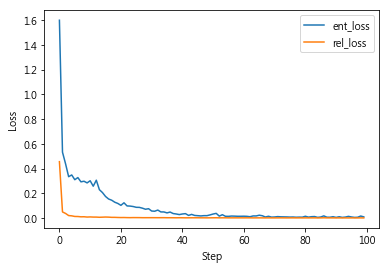

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(all_ent_loss[:100], label='ent_loss')
plt.plot(all_rel_loss[:100], label='rel_loss')
plt.xlabel("Step")
plt.ylabel("Loss") 
plt.legend()
plt.show()

In [12]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output):
    output = output.view(BATCH_SIZE,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output):
    output = output.view(BATCH_SIZE,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [13]:
# Check predictions after training
with torch.no_grad():
    r_choose = random_choose(input_var)
    model.eval()
    ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    
#     print('predict :', ent_output[0])
#     print('true :', ent_var[r_choose[0]])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    print()
    print('===================================================')
    print()
    print()
    print('predict :', index2tag(ent_output[1], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[1]], ix_to_ent_tag))
    
    print()
    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)


predict : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
true : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', '<PAD

In [67]:
with torch.no_grad():
    r_choose = random_choose(input_dev)
    model.eval()
    ent_output, rel_output = model(input_dev[r_choose].cuda() if USE_CUDA else input_dev)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_dev[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    print(r_choose[0])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print()
    print('true :', index2tag(ent_dev[r_choose[0]], ix_to_ent_tag))
    print()

    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)

24

predict : ['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

true : ['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 

In [65]:
import warnings
warnings.filterwarnings('always') 

with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(BATCH_SIZE*MAX_LEN))
        ent_output = ent_argmax(ent_output)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(BATCH_SIZE*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output)
    
        print()
        
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        # true
#         print(decode_rel(batch_ent[0], batch_rel[0]))
        
        batch_decode(ent_output, rel_output, batch_index, raw_input_dev, \
                     batch_ent, batch_rel)
        print()
        print('==========================')
        print()


Entity loss : 0.0774
Relation loss : 0.0012

['我', '的', '皮', '膚', '是', '乾', '性', '肌', ',', '雖', '然', '在', '夏', '天', '不', '會', '乾', '到', '緊', '繃', ',', '但', '每', '天', '還', '是', '要', '加', '強', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]


['極', '效', '肌', '因', '修', '護', '巨', '藻', '、', '齒', '缘', '墨', '角', '藻', '複', '合', '水', '解', '酵', '母', '提', '取', '物', '，', '浸', '透', '濕', '潤', '乾', '燥', '肌', '膚', '，', '增', '強', '防', '護', '屏', '障', '，', '協', '同', '蘆', '薈', '、', '山', '金', '車', '及', '光', '果', '甘', '草', '植', '萃', '精', '華', '，', '深', '度', '安', '撫', '同', '時', '舒', '緩', '肌', '膚', '的', '不', '適', '，', '拋', '開', '惱', '人', '的', '乾', '燥', '缺', '水', '不', '安', '讓', '肌',

['“', '酵', '母', '萃', '取', '”', '搭', '配', '“', '小', '分', '子', '玻', '尿', '酸', '”', '及', '“', '牛', '奶', '蛋', '白', '”', '使', '乾', '燥', '肌', '膚', '充', '滿', '水', '分', '，', '長', '效', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]


['當', '天', '擦', '就', '馬', '上', '覺', '得', '皮', '膚', '乾', '燥', '感', '得', '到', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['以', '前', '我', '有', '敷', '過', '別', '款', '的', '美', '白', '面', '膜', '~', '很', '容', '易', '就', '會', '讓', '我', '的', '臉', '部', '肌', '膚', '過', '敏', '，', '會', '有', '紅', '紅', '的', '臉', '出', '現']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']


['以', '上', '是', '我', '不', '會', '再', '使', '用', '此', '產', '品', '，', '也', '不', '會', '推', '薦', '親', '友', '使', '用', '的', '原', '因', '，', '最', '大', '原', '因', '是', '因', '為', '；', '居', '然', '在', '使', '用', '後', '，', '肌', '膚', '反', '而', '變', '得', '乾', '到', '發', '癢', '，', '可', '見', '產', '品', '若', '無', '法', '真', '正', '提', '供', '乾', '性', '肌', '膚', '滋', '潤', '和', '保', '濕', '的', '話'

['溫', '柔', '而', '堅', '定', '的', '修', '護', '力', 'Z', 'e', 'p', 'h', 'y', 'r', 'i', 'n', 'e', '數', '字', '保', '養', ',', '非', '常', '溫', '和', '的', '產', '品', '即', '使', '是', '敏', '感', '肌', '也', '可', '以', '輕', '鬆', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '']


['可', '視', '膚', '況', '/', '氣', '候', '選', '擇', '厚', '敷', 'o', 'r', '薄', '敷', '，', '不', '論', '是', '救', '急', '保', '養', '或', '是', '乾', '肌', '日', '常', '補', '水', '，', '保', '濕', '效', '果', '皆', '相', '當', '顯', '著', '，', '簡', '直', '宜', '家', '宜', '室', '四', '季', '皆', '宜', '齁', '~']
['O', 'O', 'O', 'O', 'O', 'O', '

ValueError: Found input variables with inconsistent numbers of samples: [770, 736]

In [ ]:
# from sklearn.metrics import precision_recall_fscore_support

# def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel):
#     rel_lists = []
#     combine_outputs = []
#     combine_trues = []
    
#     for e,r,i in zip(ent_output, rel_output, batch_index):
#         r_list, appear_error = decode_rel(e, r)
#         if appear_error:
#             continue
            
#         rel_lists.append(r_list)
        
#         len_of_list = len(word_lists[i])
#         word_list = word_lists[i]
#         pridict_ent = index2tag(e, ix_to_ent_tag)
        
        
        
#         print(word_list)
#         print(pridict_ent[:len_of_list])
#         print(r_list[:len_of_list])
        
#         for word in range(len_of_list):
#             add_r = ''
#             if type(r_list[word]) is list:
#                 for single_r in r_list[word]:
#                     add_r = add_r+single_r+' '
#             combine_outputs.append(word_list[word]+' '+pridict_ent[word]+' '+add_r)
        
#         combine_outputs.append(" ")
#         print()
#         print('==========================')
#         print()
        
        
    
#     print(precision_recall_fscore_support(combine_trues, combine_outputs, average='macro'))



# def decode_rel(ent_output, rel_output):
#     r_list = []
#     r_dict = {}
#     appear_error = False
#     pred_ent = index2tag(ent_output, ix_to_ent_tag)

#     e_loc = 0
#     for loc, e in enumerate(pred_ent):
#         if e[0]=='B':
#             e_loc = loc
#             r_dict[loc] = {
#                 '_2ndtag':e[2:],
#                 'end':loc,
#             }
#             r_list.append([])
            
        
#         elif e[0]=='I':
            
#             # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
#             # 所以沒有紀錄e_loc
#             try: 
#                 r_dict[e_loc]['end'] = loc
#             except KeyError:
#                 appear_error = True
#                 break
#             r_list.append([])
            
#         else:
#             r_list.append("")
    
    
#     IsB = False
#     IsNext = False
#     num_reocrd = -1
#     now_loc = 0
#     end_loc = 0
#     tag = ""
#     preAorB = ""
#     nowAorB = ""
#     pre_complete_rel = ""
#     now_complete_rel = ""
#     rel_keyerror = False
    
#     for now in range(len(rel_output)):
#         for loc, rel in enumerate(rel_output[now][:now+1]):
#             rel = rel.cpu().numpy()

#             if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

#                 IsB = True
#                 IsNext = True
#                 tag = ix_to_rel_tag[int(rel)]
#                 num_reocrd+=1
                
#                 now_loc = loc
                
#                 # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
#                 # 但在entity中卻沒有預測出來，所以r_dict中沒有紀錄
#                 try:
#                     end_loc = r_dict[now_loc]['end']
#                 except KeyError:
#                     rel_keyerror = True
#                     break
                
                
#                 second_tag = r_dict[now_loc]['_2ndtag']
#                 preAorB = check_loc(second_tag)
#                 nowAorB = 'B' if preAorB=='A' else 'A'
                
#                 pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
#                 now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
#                 for token in range(now_loc, end_loc+1):
#                     r_list[token].append(pre_complete_rel)
                
#                 r_list[now].append(now_complete_rel)

                
#             elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
#                 if loc<=end_loc:
#                     pass
#                 else:
#                     IsB = False
            
#             elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
#                 r_list[now] = r_list[now-1]
                
#             else:
#                 IsB = False
        
#         if rel_keyerror:
#             rel_keyerror = False
#             break
                
                
#     return r_list, appear_error
                

                
# def check_loc(second_tag):
#     if second_tag in rule[0]:
#         return 'A'
#     elif second_tag in rule[2]:
#         return 'B'

In [62]:
from sklearn.metrics import precision_recall_fscore_support

def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel):
    rel_lists = []
    combine_outputs = []
    combine_trues = []
    
    for e,r,i in zip(ent_output, rel_output, batch_index):
        r_list, appear_error = decode_rel(e, r)
        if appear_error:
            continue
            
        rel_lists.append(r_list)
        
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        pridict_ent = index2tag(e, ix_to_ent_tag)
        
        
        
        print(word_list)
        print(pridict_ent[:len_of_list])
        print(r_list[:len_of_list])
        
        for word in range(len_of_list):
            add_r = ''
            if type(r_list[word]) is list:
                for single_r in r_list[word]:
                    add_r = add_r+single_r+' '
            combine_outputs.append(word_list[word]+' '+pridict_ent[word]+' '+add_r)
        
        combine_outputs.append(" ")
        print()
        print('==========================')
        print()
        
        
    # true 
    for e,r,i in zip(true_ent, true_rel, batch_index):
        r_list, appear_error = decode_rel(e, r)
        if appear_error:
            continue
            
        rel_lists.append(r_list)
        
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        pridict_ent = index2tag(e, ix_to_ent_tag)

        
        for word in range(len_of_list):
            add_r = ''
            if type(r_list[word]) is list:
                for single_r in r_list[word]:
                    add_r = add_r+single_r+' '
            combine_trues.append(word_list[word]+' '+pridict_ent[word]+' '+add_r)
        
        combine_trues.append(" ")
    

    
    print(combine_outputs)
    print(np.array(combine_outputs))
    print('=================')
    
#     print(precision_recall_fscore_support(combine_trues, combine_outputs, average='macro', \
#                                           labels=np.unique(combine_outputs)))

    print(precision_recall_fscore_support(combine_trues, combine_outputs, average='macro'))



def decode_rel(ent_output, rel_output):
    r_list = []
    r_dict = {}
    appear_error = False
    pred_ent = index2tag(ent_output, ix_to_ent_tag)

    e_loc = 0
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
            
        
        elif e[0]=='I':
            
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            r_list.append([])
            
        else:
            r_list.append("")
    
    
    IsB = False
    IsNext = False
    num_reocrd = -1
    now_loc = 0
    end_loc = 0
    tag = ""
    preAorB = ""
    nowAorB = ""
    pre_complete_rel = ""
    now_complete_rel = ""
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()

            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 但在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    end_loc = r_dict[now_loc]['end']
                except KeyError:
                    rel_keyerror = True
                    break
                
                
                second_tag = r_dict[now_loc]['_2ndtag']
                preAorB = check_loc(second_tag)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                for token in range(now_loc, end_loc+1):
                    r_list[token].append(pre_complete_rel)
                
                r_list[now].append(now_complete_rel)

                
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                if loc<=end_loc:
                    pass
                else:
                    IsB = False
            
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
            else:
                IsB = False
        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

                
def check_loc(second_tag):
    if second_tag in rule[0]:
        return 'A'
    elif second_tag in rule[2]:
        return 'B'